# Political Messaging and Audience Engagement on Social Media

This notebook analyzes how different political messaging themes influence audience engagement on Facebook posts using reaction dynamics and topic modeling.


**Dataset availability:**  
The dataset used in this analysis was provided for academic use and cannot be redistributed. The notebook is shared to demonstrate the analytical workflow, modeling decisions, and interpretation of results.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
df = pd.read_csv("data/Donald Trumps Facebook Statuses.csv")

## Content Types and Posting Behavior

In [6]:
status_types = df['status_type'].value_counts()
#status_types
valid_status_types = ['photo', 'status', 'link', 'video']
df_filtered = df[df['status_type'].isin(valid_status_types)].copy()
df_filtered['status_type'].value_counts()

status_type
photo     1539
status    1177
link       763
video      679
Name: count, dtype: int64

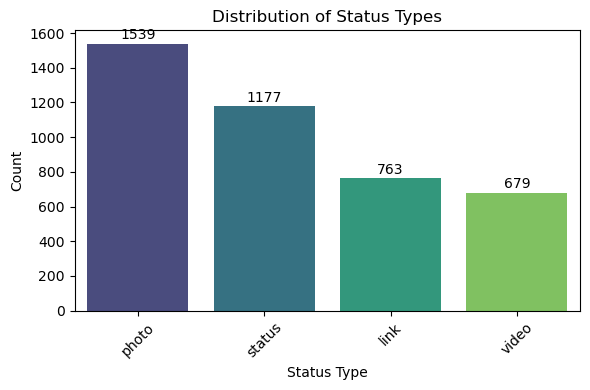

In [7]:
# Count each status type
status_counts = df_filtered['status_type'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=status_counts.index, 
    y=status_counts.values, 
    hue=status_counts.index,
    palette="viridis",
    legend=False
)
plt.xlabel("Status Type")
plt.ylabel("Count")
plt.title("Distribution of Status Types")
plt.xticks(rotation=45)

# Adding counts on top of each bar
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2., 
        p.get_height() + 50, 
        int(p.get_height()), 
        ha='center', 
        va='center', 
        fontsize=10
    )

plt.tight_layout()
plt.show()

## Temporal Dynamics of Audience Reactions

In [9]:
 # Converting the status_published column to a datetime column
df_filtered['status_published'] = pd.to_datetime(df_filtered['status_published'], format="%m/%d/%Y %H:%M:%S", errors='coerce')
# Dropping rows with missing values in any of the 5 relevant columns
df_filtered = df_filtered.dropna(subset=['status_published', 'num_likes','num_loves', 'num_sads', 'num_angrys'])
# Sort by time
df_filtered_sorted = df_filtered.sort_values(by='status_published')

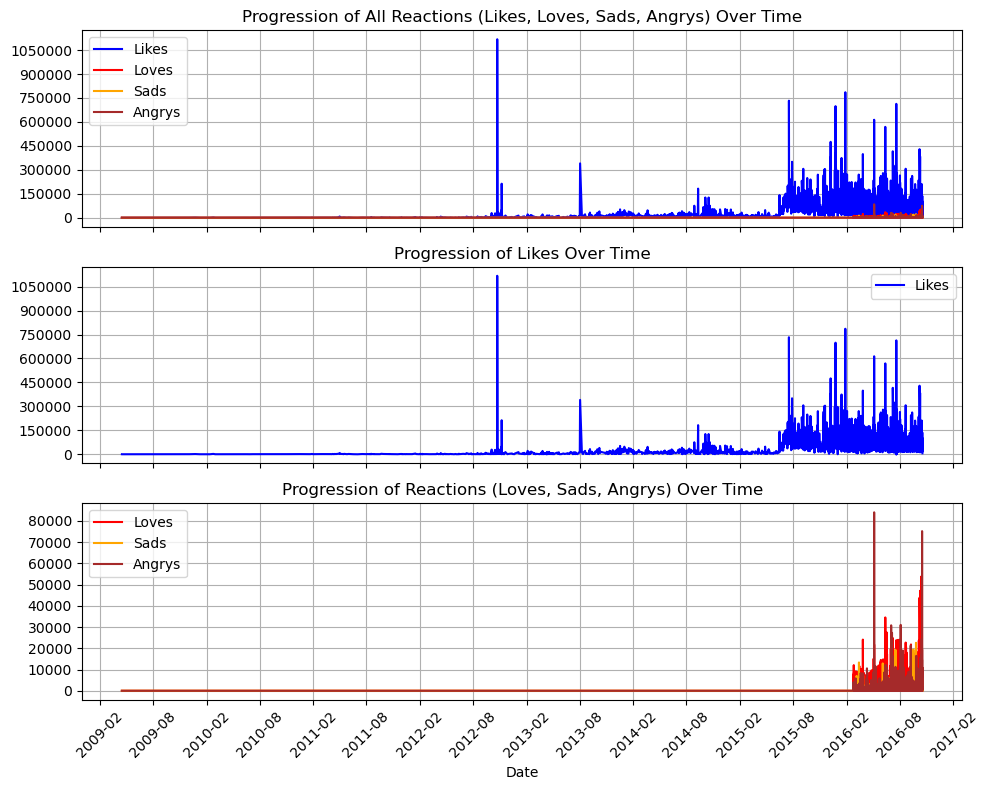

In [10]:
# Plotting 3 charts: first for all reactions, second for only likes, third for loves sads angrys
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# 1st Chart: all reactions (Likes, Loves, Sads, Angrys)
axes[0].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_likes'], label='Likes', color='blue')
axes[0].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_loves'], label='Loves', color='red')
axes[0].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_sads'], label='Sads', color='orange')
axes[0].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_angrys'], label='Angrys', color='brown')
axes[0].set_title("Progression of All Reactions (Likes, Loves, Sads, Angrys) Over Time")
axes[0].legend()
axes[0].grid(True)

# 2nd Chart: Likes only
axes[1].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_likes'], label='Likes', color='blue')
axes[1].set_title("Progression of Likes Over Time")
axes[1].legend()
axes[1].grid(True)

# 3rd Chart: Loves, Sads, and Angrys
axes[2].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_loves'], label='Loves', color='red')
axes[2].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_sads'], label='Sads', color='orange')
axes[2].plot(df_filtered_sorted['status_published'], df_filtered_sorted['num_angrys'], label='Angrys', color='brown')
axes[2].set_title("Progression of Reactions (Loves, Sads, Angrys) Over Time")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].grid(True)

# Format the x-axis to display every 6 months
axes[2].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Formatting for all axes
for ax in axes:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Dominant Engagement Patterns

Because likes dominate reaction volume, reactions are visualized separately to preserve interpretability for lower-frequency reactions.

"Expanded" (newer) reaction types appear only after early 2016. While likes remain dominant, angry reactions exhibit the largest spikes, which suggests stronger emotional responses during politically charged periods.

## Topic Modeling of Political Messaging

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Using the same text preprocessing function as the previous workshop
TAG_RE = re.compile(r'<.*?>') # Detects HTML tags
NUM_RE = re.compile(r'\d+') # Detects numbers
PUNC_RE = re.compile(r'[^\w\s]') # Detects anything that isn't a word \w or a whitespace \s
SPACE_RE = re.compile(r'\s+') # Detects any extra whitespace
USERNAME_RE = re.compile(r'@\w+') # Detects twitter usernames (any word following "@")


def clean_text(text):
    text = USERNAME_RE.sub('', text) # Remove usernames
    text = TAG_RE.sub('', text) # Remove HTML tags
    text = text.lower() # Convert to lowercase
    text = NUM_RE.sub('', text) # Remove numbers
    text = PUNC_RE.sub('', text) # Remove punctuation
    text = SPACE_RE.sub(' ', text).strip() # Remove extra whitespace
    words = word_tokenize(text) # Tokenizing
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Lemmatization
    return ' '.join(words)

In [15]:
# Filtering out rows with missing values in any relevant columns (status, shares and reactions)
df_filtered = df.dropna(subset=['status_message', 'num_shares', 'num_reactions']).copy()
# Applying text preprocessing
df_filtered['cleaned_status_message'] = df_filtered['status_message'].apply(clean_text)
# Vectorizing using tf-idf
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_filtered['cleaned_status_message'])

In [16]:
# Applying LDA to identify topics (using 10 topics)
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [17]:
# Getting the top 10 words for each topic
words = vectorizer.get_feature_names_out()
top_words = {}
for i, topic in enumerate(lda.components_):
    top_word_indices = topic.argsort()[-10:][::-1]
    top_word_list = [words[i] for i in top_word_indices]
    top_words[i] = top_word_list
    
print("Top words per topic:")
for topic, words in top_words.items():
    print(f"Topic {topic + 1}: {', '.join(words)}")

Top words per topic:
Topic 1: america, great, thank, make, support, trump, safe, vote, let, love
Topic 2: cruz, ted, mitt, romney, lyin, trump, like, think, rubio, marco
Topic 3: apprentice, hillary, clinton, nbc, celebapprentice, crooked, question, bad, tonight, premiere
Topic 4: iowa, momentum, caucus, makeamericagreatagain, record, finder, rncincle, american, people, httpswwwdonaldjtrumpcomiowacaucusfinder
Topic 5: happy, supertuesday, father, joe, trump, birthday, hillary, people, flashbackfriday, read
Topic 6: golf, scotland, tbt, link, trump, course, international, thanks, world, clinton
Topic 7: hillary, american, clinton, people, job, silent, crooked, million, country, talk
Topic 8: makeamericagreatagain, president, trump, law, country, wall, miss, deal, build, border
Topic 9: trumpadvice, national, trump, doral, miami, bush, club, golf, obamacare, going
Topic 10: watch, trump, press, clinton, hillary, pm, president, dont, live, radical


Our LDA model reveals some interesting patterns, but also highlights areas where it struggles with distinguishing between themes. One major issue is the overlap of certain terms like "Hillary", "Clinton" and "Trump" across multiple topics. For instance, "Clinton" appears in topics related to both Hillary Clinton's political campaign and broader political discourse, while "Trump" appears in topics covering his political campaign, personal branding, and business ventures. This overlap suggests that the model is having trouble separating these distinct aspects of Trump’s messaging. Additionally, terms like "makeamericagreatagain" appear across topics, indicating that the model is likely grouping political campaign-related content too broadly. Despite this, the model does manage to capture certain themes like the Iowa Caucus under a single topic (topic 4). The topics below reflect recurring themes in Trump’s messaging rather than perfectly distinct semantic categories.

Topic interpretation:  
Topic 1 relates to classic pro-America Trumpian campaign language. We find words such as america, great, vote, etc.  
Topic 2 relates to Trump's political republican rivals, such as Ted Cruz, Mitt Romney, Marco Rubio. There are also words like "lying" which suggests that this topic involves Trump attacking these political rivals.  
Topic 3 seems to relates to TV appearances (tonight, premiere, nbc) and attacks on Hillary Clinton.  
Topic 4 relates to the Iowa Caucus, which makes sense because it was an important strategic moment in Trump's 2016 campaign.  
Topic 5 seems to relates to more personal and celebratory posts, as it includes casual and non-political words like happy, birthday, father, flashbackfriday...  
Topic 6 relates to Trump's golf courses and international businesses, with emphasis on personal branding and promotion. This topic likely mixes promotional content with subtle political undertones.  
Topic 7 relates to Hillary Clinton and her policies, likely framed as hurting American jobs and people.  
Topic 8 relates to immigration, a central issue for Trump's campaign in 2016. It contains words like wall, law, build, border and country.  
Topic 9 seems to relate to various things. It includes some personal branding (Trump Doral), some policy (Obamacare), and other words.  
Topic 10 relates to live events, likely pushing people to tune in and support Trump.  

Topic overlap reflects limitations of LDA on entity-heavy political text and suggests that contextual embeddings or entity removal could improve separation.

## Can Reactions Be Used as a Proxy for Sentiment?


LDA identifies themes in the text but does not capture sentiment. Reactions can be treated as a rough proxy for audience emotion, but any mapping (e.g., loves = positive, angry = negative) is an assumption and should be validated. A simple next step would be to define a reaction-based score (for example, +1 for likes, +2 for loves, -1 for sads and -2 for angrys) and compare it across topics, then sanity-check against a sentiment model or manually labeled examples.

## Content Themes Associated with High Engagement


In [22]:
topic_distributions = lda.transform(X)

# df_topics contains the topic probabilities for each status message in df_filtered (aka topic distributions)
# (a score for each status_message outlining the probabilities that it belongs to any of the 10 topics
df_topics = pd.DataFrame(topic_distributions, columns=[f"topic_{i+1}" for i in range(lda.n_components)])
df_with_topics = pd.concat([df_filtered, df_topics], axis=1)

In [23]:
# Correlating each topic with num_shares
# Getting all high-share posts (posts with shares > median shares)
high_shares = df_with_topics[df_with_topics['num_shares'] > df_with_topics['num_shares'].median()]
# Calculating the mean topic distribution for all high-share posts:
mean_topic_dist = high_shares[[f"topic_{i+1}" for i in range(lda.n_components)]].mean()

# Printing which topics are most common in high-share posts in descending order
print("Topics associated with high shares (in descending order):")
print(mean_topic_dist.sort_values(ascending=False))

Topics associated with high shares (in descending order):
topic_1     0.275473
topic_8     0.119104
topic_7     0.116256
topic_10    0.105474
topic_3     0.074140
topic_9     0.069042
topic_2     0.066321
topic_6     0.060637
topic_5     0.058460
topic_4     0.055094
dtype: float64


High-share posts are most strongly associated with campaign-oriented messaging (Topic 1), immigration/border themes (Topic 8), and anti-opponent framing (Topic 7). Topic 10 (live events) also ranks highly, suggesting real-time media posts were more likely to be amplified.

In [25]:
# Correlating each topic with num_reactions
# Getting all high-reaction posts (posts with reactions > median reactions)
high_reactions = df_with_topics[df_with_topics['num_reactions'] > df_with_topics['num_reactions'].median()]
# Calculating the mean topic distribution for all high-reaction posts:
mean_topic_dist = high_reactions[[f"topic_{i+1}" for i in range(lda.n_components)]].mean()

# Printing which topics are most common in high-reaction posts in descending order
print("Topics associated with high reactions (in descending order):")
print(mean_topic_dist.sort_values(ascending=False))

Topics associated with high reactions (in descending order):
topic_1     0.274490
topic_7     0.117866
topic_8     0.116012
topic_10    0.099787
topic_9     0.071889
topic_3     0.071395
topic_2     0.069687
topic_5     0.061295
topic_4     0.058946
topic_6     0.058632
dtype: float64


The ordering of topics based on high reactions numbers is almost identical to the order based on high share numbers, suggesting that the content driving shares is also the same content that drives the most engagement (reactions) from fans.  
Topic 1 (pro-America, campaign language) leads once again in this category, followed by Topic 7 (Hillary Clinton and job policies) and Topic 8 (immigration and the border), indicating these core political themes generated both a high number of shares and reactions.  
Topic 10 (live events) again shows up in the fourth position, highlighting that content related to real-time events resonate strongly with fans.  

The close alignment of the two lists shows that the content generating the most shares and reactions is content associated with topics 1,7,8 and 10. In other words, Trump's fans are more engaged with content that promotes pro-Trump campaign messaging, attacks on Hillary Clinton, the political issues of immigration and the border, and pro-American sentiment.

## Key Takeaways

Audience engagement is not evenly distributed across content themes. Posts centered on campaign messaging, national identity, and political opponents consistently generate higher engagement, both in shares and in reactions.

Likes remain the dominant reaction throughout the dataset, but the introduction of additional reactions after early 2016 adds more signal about the tone of engagement. In particular, angry reactions show sharper spikes than other reactions, which likely reflects stronger emotional responses to certain posts.

Finally, the topics most associated with high shares are largely the same as those associated with high reaction counts. This suggests that the content most likely to be amplified through sharing is also the content that tends to generate the strongest audience response.

## Limitations and Future Work

LDA struggles with entity-heavy political text, which contributes to topic overlap. Reactions provide a useful engagement signal but only approximate emotion and do not directly measure sentiment. A natural next step would be to combine topic modeling with a sentiment model (or a small labeled sample) and to test contextual embeddings to improve theme separation.
